# **Análise de temporal de preços de casas em Londres e previsão com algoritmos determinísticos**

Nesse trabalho irei analisar dados dos preços médios de casa em Londres e utilizar algoritmos de suavização exponencial para modelar essas séries temporais e gerar previsões. Os modelos de suavização (ou alisamento) exponecial são bastante usados na indústria e no comércio.

Esses algoritmos são chamados de determinísticos, pois não lhe são atribuídos nenhum comportamento estocástico; ou seja, não há uma base probabilística, não seguem um processo aleatório. A previsões são geradas com base nas observações passadas 

A suposição desses algoritmos é que o comportamento das séries temporais observadas é determinado por uma ou mais componentes não observáveis. A vantagem desses algoritmos é que eles são de fácil manipulação, entendimento e aplicação.


Aqui iremos trabalhar com 4 tipos de algoritmos de suavização exponecial:

1) Algoritmo de suavização **Simples**;

2) Algoritmo de suavização **Holt**;

3) Algoritmo de suavização **Holt-Winter**;

4) Algoritmo de suavização **Pegels**.

E iremos falar de cada um desses algoritmos e como funcionam.

## Dados

Os dados sobre os preços médio foram obtidos no Kaggle no link [aqui](https://www.kaggle.com/justinas/housing-in-london).
Os dados vão do ano de 1995 a 2020, com periodicidade mensal. As colunas trazem a área que as casas estão localizadas, o preço médio da casa, o código, o número de casas vendidas, o número de crimes e, a última coluna, que indica se é ou não um bairro de Londres.

## Importando as Bibliotecas

In [1]:
import pandas as pd
import datetime
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

Matplotlib is building the font cache; this may take a moment.


## Importação dos dados

In [4]:
house=pd.read_csv('housing_london.csv',encoding='utf-8',index_col='date')

## Breve análise de dados

Visualizando as primeiras 5 observações.

In [5]:
house.head()

,area,average_price,code,houses_sold,no_of_crimes,borough_flag
date,,,,,,
1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1995-02-01,city of london,82203,E09000001,7.0,NaN,1
1995-03-01,city of london,79121,E09000001,14.0,NaN,1
1995-04-01,city of london,77101,E09000001,7.0,NaN,1
1995-05-01,city of london,84409,E09000001,10.0,NaN,1


Reordenando o dataset para que a série de tempo esteja ordenada corretamente.

In [6]:
house=house.sort_index(ascending=True)

Extraindo os anos.

In [7]:
lista=[]
for i in house.index:
    lista.append(i.split('-')[0])

house['year']=lista

In [8]:
lista

['1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 '1995',
 

Extraindo os meses.

In [9]:
lista2=[]
for i in house.index:
    lista2.append(i[5:7])

house['month']=lista2

Visualizando novamente o *dataset*.

In [10]:
house.head(100)

,area,average_price,code,houses_sold,no_of_crimes,borough_flag,year,month
date,,,,,,,,
1995-01-01,city of london,91449,E09000001,17.0,NaN,1,1995,01
1995-01-01,greenwich,62300,E09000011,182.0,NaN,1,1995,01
1995-01-01,north east,42076,E12000001,1983.0,NaN,0,1995,01
1995-01-01,enfield,72515,E09000010,327.0,NaN,1,1995,01
1995-01-01,north west,43958,E12000002,5801.0,NaN,0,1995,01
...,...,...,...,...,...,...,...,...
1995-03-01,enfield,72190,E09000010,437.0,NaN,1,1995,03
1995-03-01,barnet,92248,E09000003,384.0,NaN,1,1995,03
1995-03-01,ealing,81380,E09000009,377.0,NaN,1,1995,03


Na coluna '*area*' há cerca de 45 valores únicos.

In [11]:
house['area'].nunique()

45

Abaixo podemos observar esses 45 valores.

In [12]:
house['area'].unique()

array(['city of london', 'greenwich', 'north east', 'enfield',
       'north west', 'ealing', 'yorks and the humber', 'croydon',
       'east midlands', 'outer london', 'camden', 'bromley',
       'east of england', 'brent', 'london', 'bexley', 'south east',
       'barnet', 'south west', 'west midlands', 'hackney', 'inner london',
       'hammersmith and fulham', 'lambeth', 'merton',
       'kingston upon thames', 'newham', 'kensington and chelsea',
       'redbridge', 'richmond upon thames', 'islington', 'southwark',
       'hounslow', 'sutton', 'hillingdon', 'tower hamlets', 'havering',
       'waltham forest', 'harrow', 'wandsworth', 'haringey',
       'westminster', 'barking and dagenham', 'england', 'lewisham'],
      dtype=object)

Para cada dessas localidades há pelo menos 301 observações.

In [13]:
house['area'].value_counts()

hackney                   302
enfield                   302
tower hamlets             302
south east                302
greenwich                 301
inner london              301
barnet                    301
croydon                   301
southwark                 301
newham                    301
england                   301
westminster               301
camden                    301
merton                    301
london                    301
kingston upon thames      301
kensington and chelsea    301
redbridge                 301
waltham forest            301
east of england           301
sutton                    301
lewisham                  301
west midlands             301
islington                 301
bexley                    301
yorks and the humber      301
brent                     301
harrow                    301
richmond upon thames      301
hillingdon                301
east midlands             301
hounslow                  301
lambeth                   301
ealing    

Informações sobre cada coluna.

In [14]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13549 entries, 1995-01-01 to 2020-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           13549 non-null  object 
 1   average_price  13549 non-null  int64  
 2   code           13549 non-null  object 
 3   houses_sold    13455 non-null  float64
 4   no_of_crimes   7439 non-null   float64
 5   borough_flag   13549 non-null  int64  
 6   year           13549 non-null  object 
 7   month          13549 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 952.7+ KB


Os tipos de cada coluna.

In [15]:
house.dtypes

area              object
average_price      int64
code              object
houses_sold      float64
no_of_crimes     float64
borough_flag       int64
year              object
month             object
dtype: object

A colunas 'houses_sold' e 'no_of_crimes' são as únicas que possuem valores faltantes.

In [16]:
house.isna().sum()

area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
year                0
month               0
dtype: int64

Abaixo podemos ver a série temporal do preço médios das casas.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


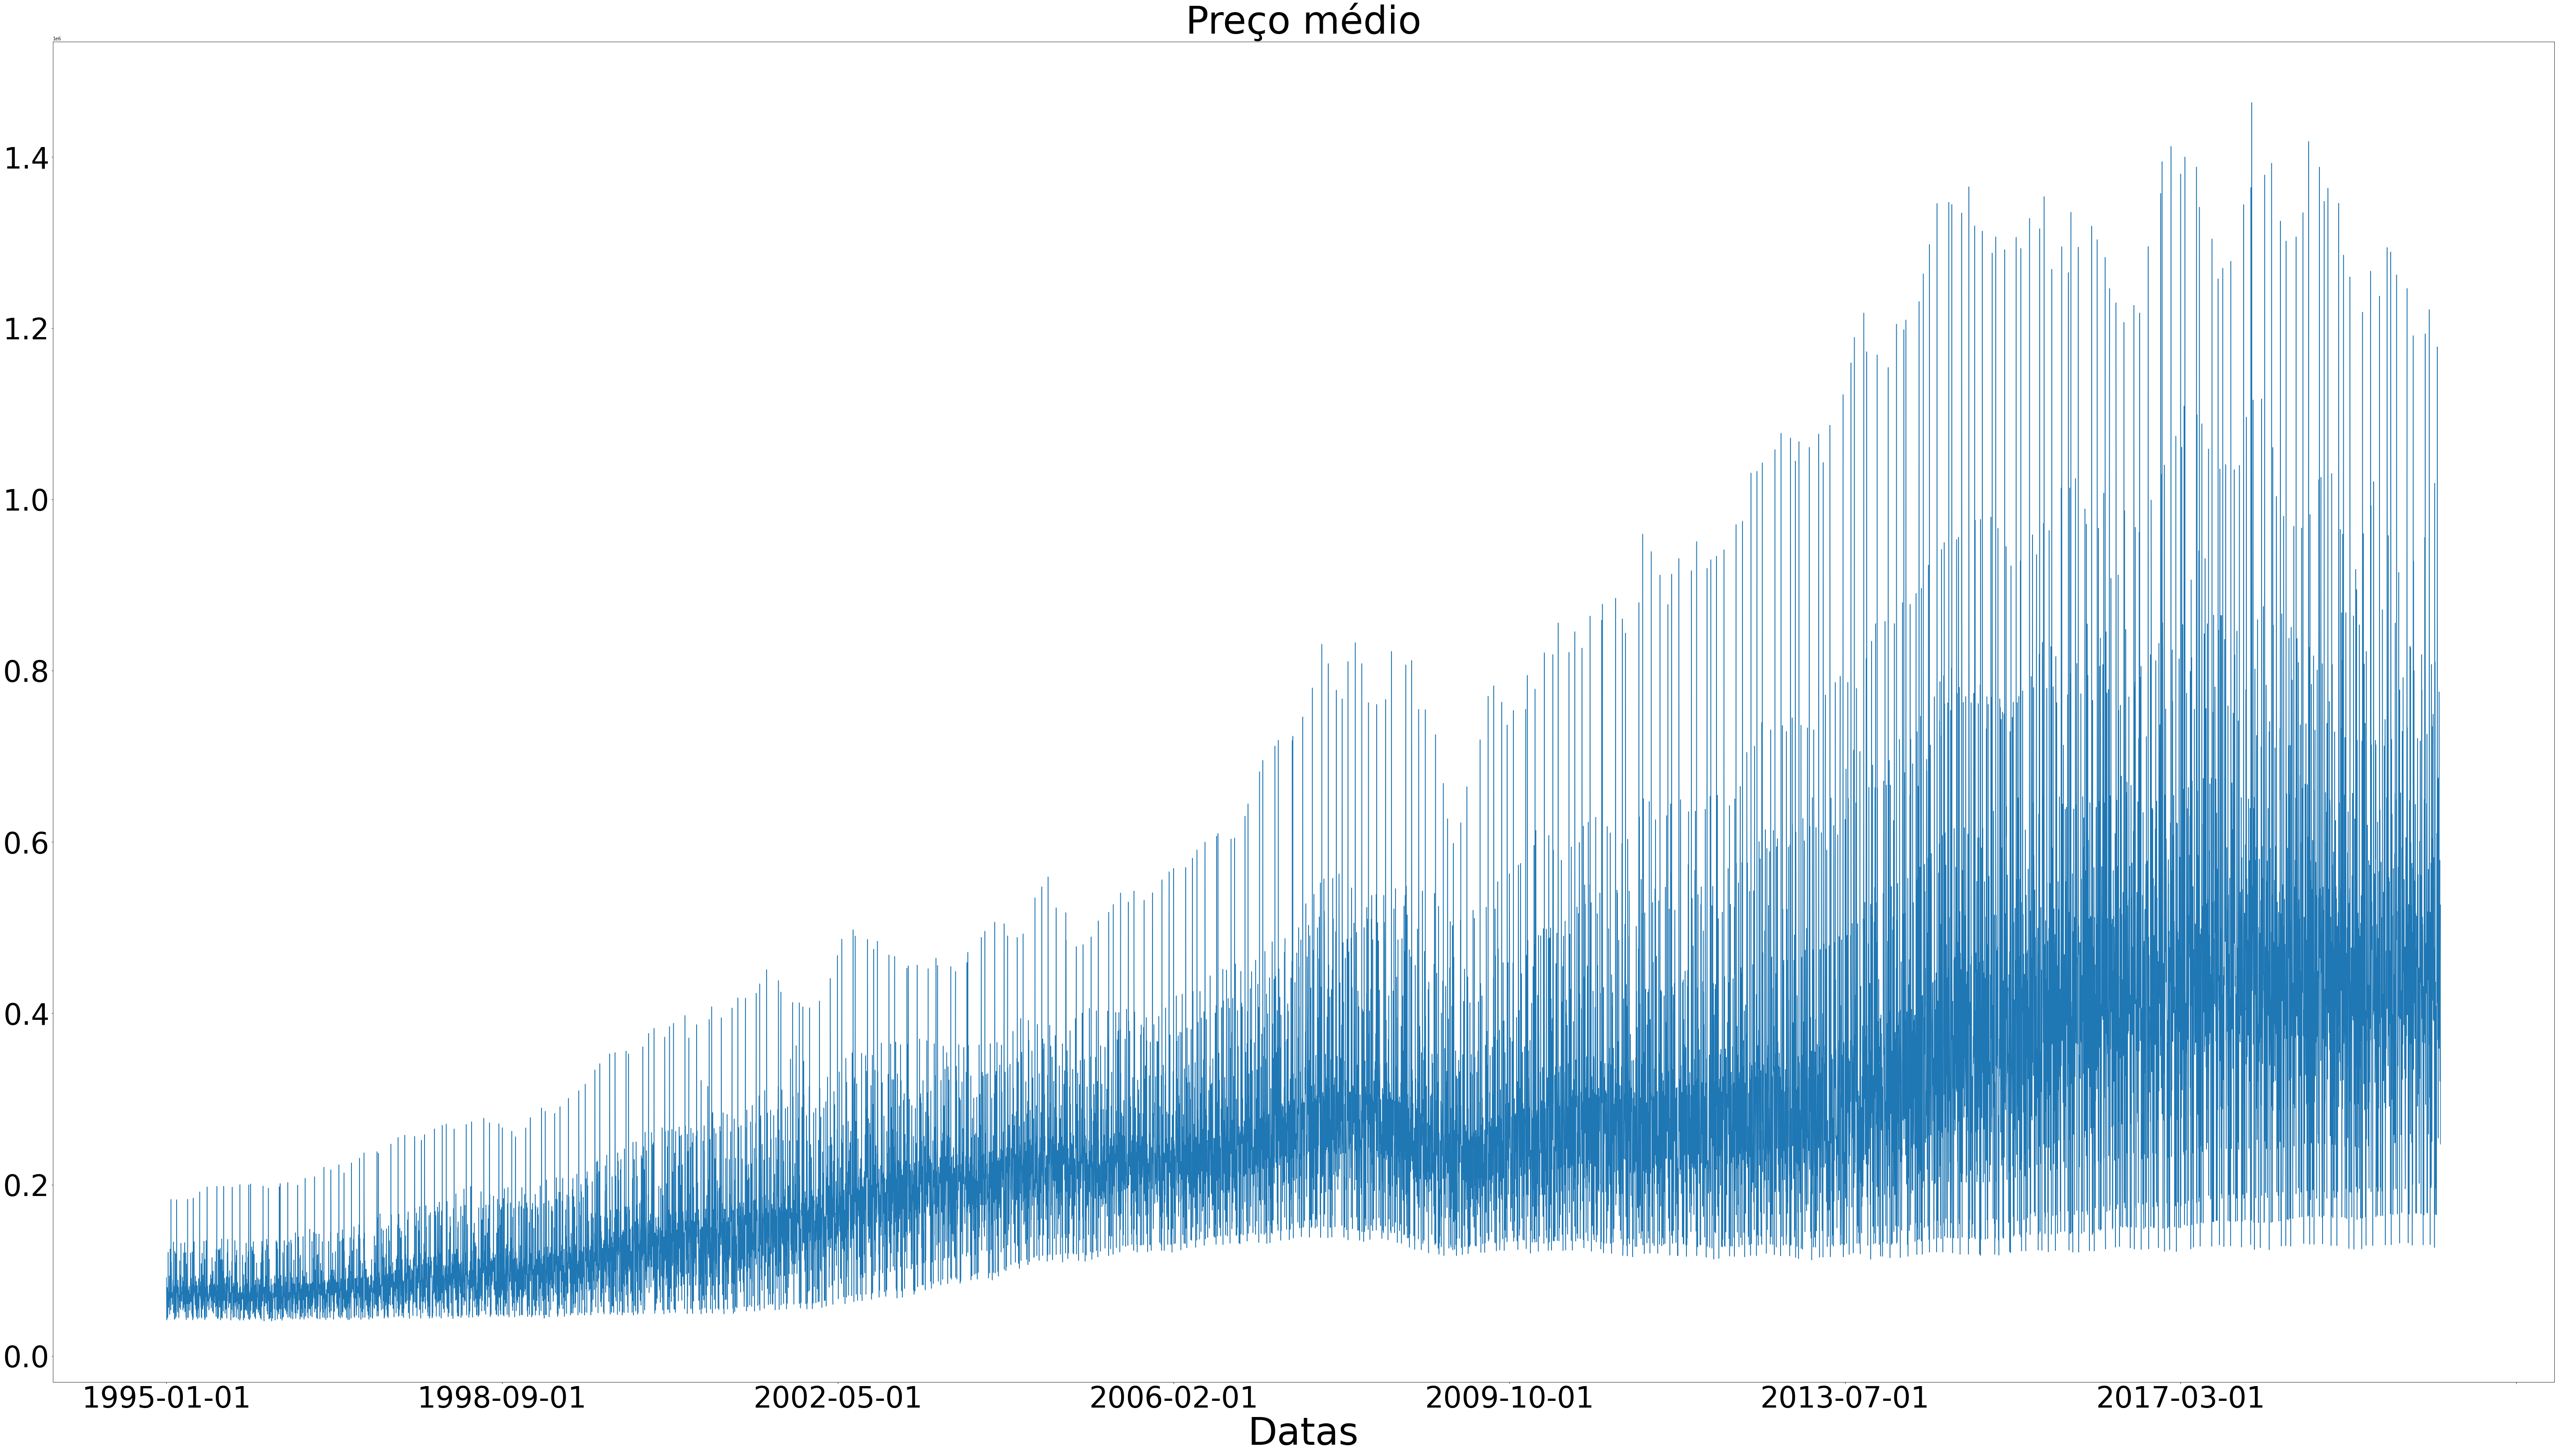

In [17]:
house['average_price'].plot(figsize=(100,55))
plt.xlabel('Datas',size=85)
plt.title('Preço médio',size=85)
plt.xticks(size=65)
plt.yticks(size=65)
plt.show()

O gráfico de preços médio, mas logaritmizados.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


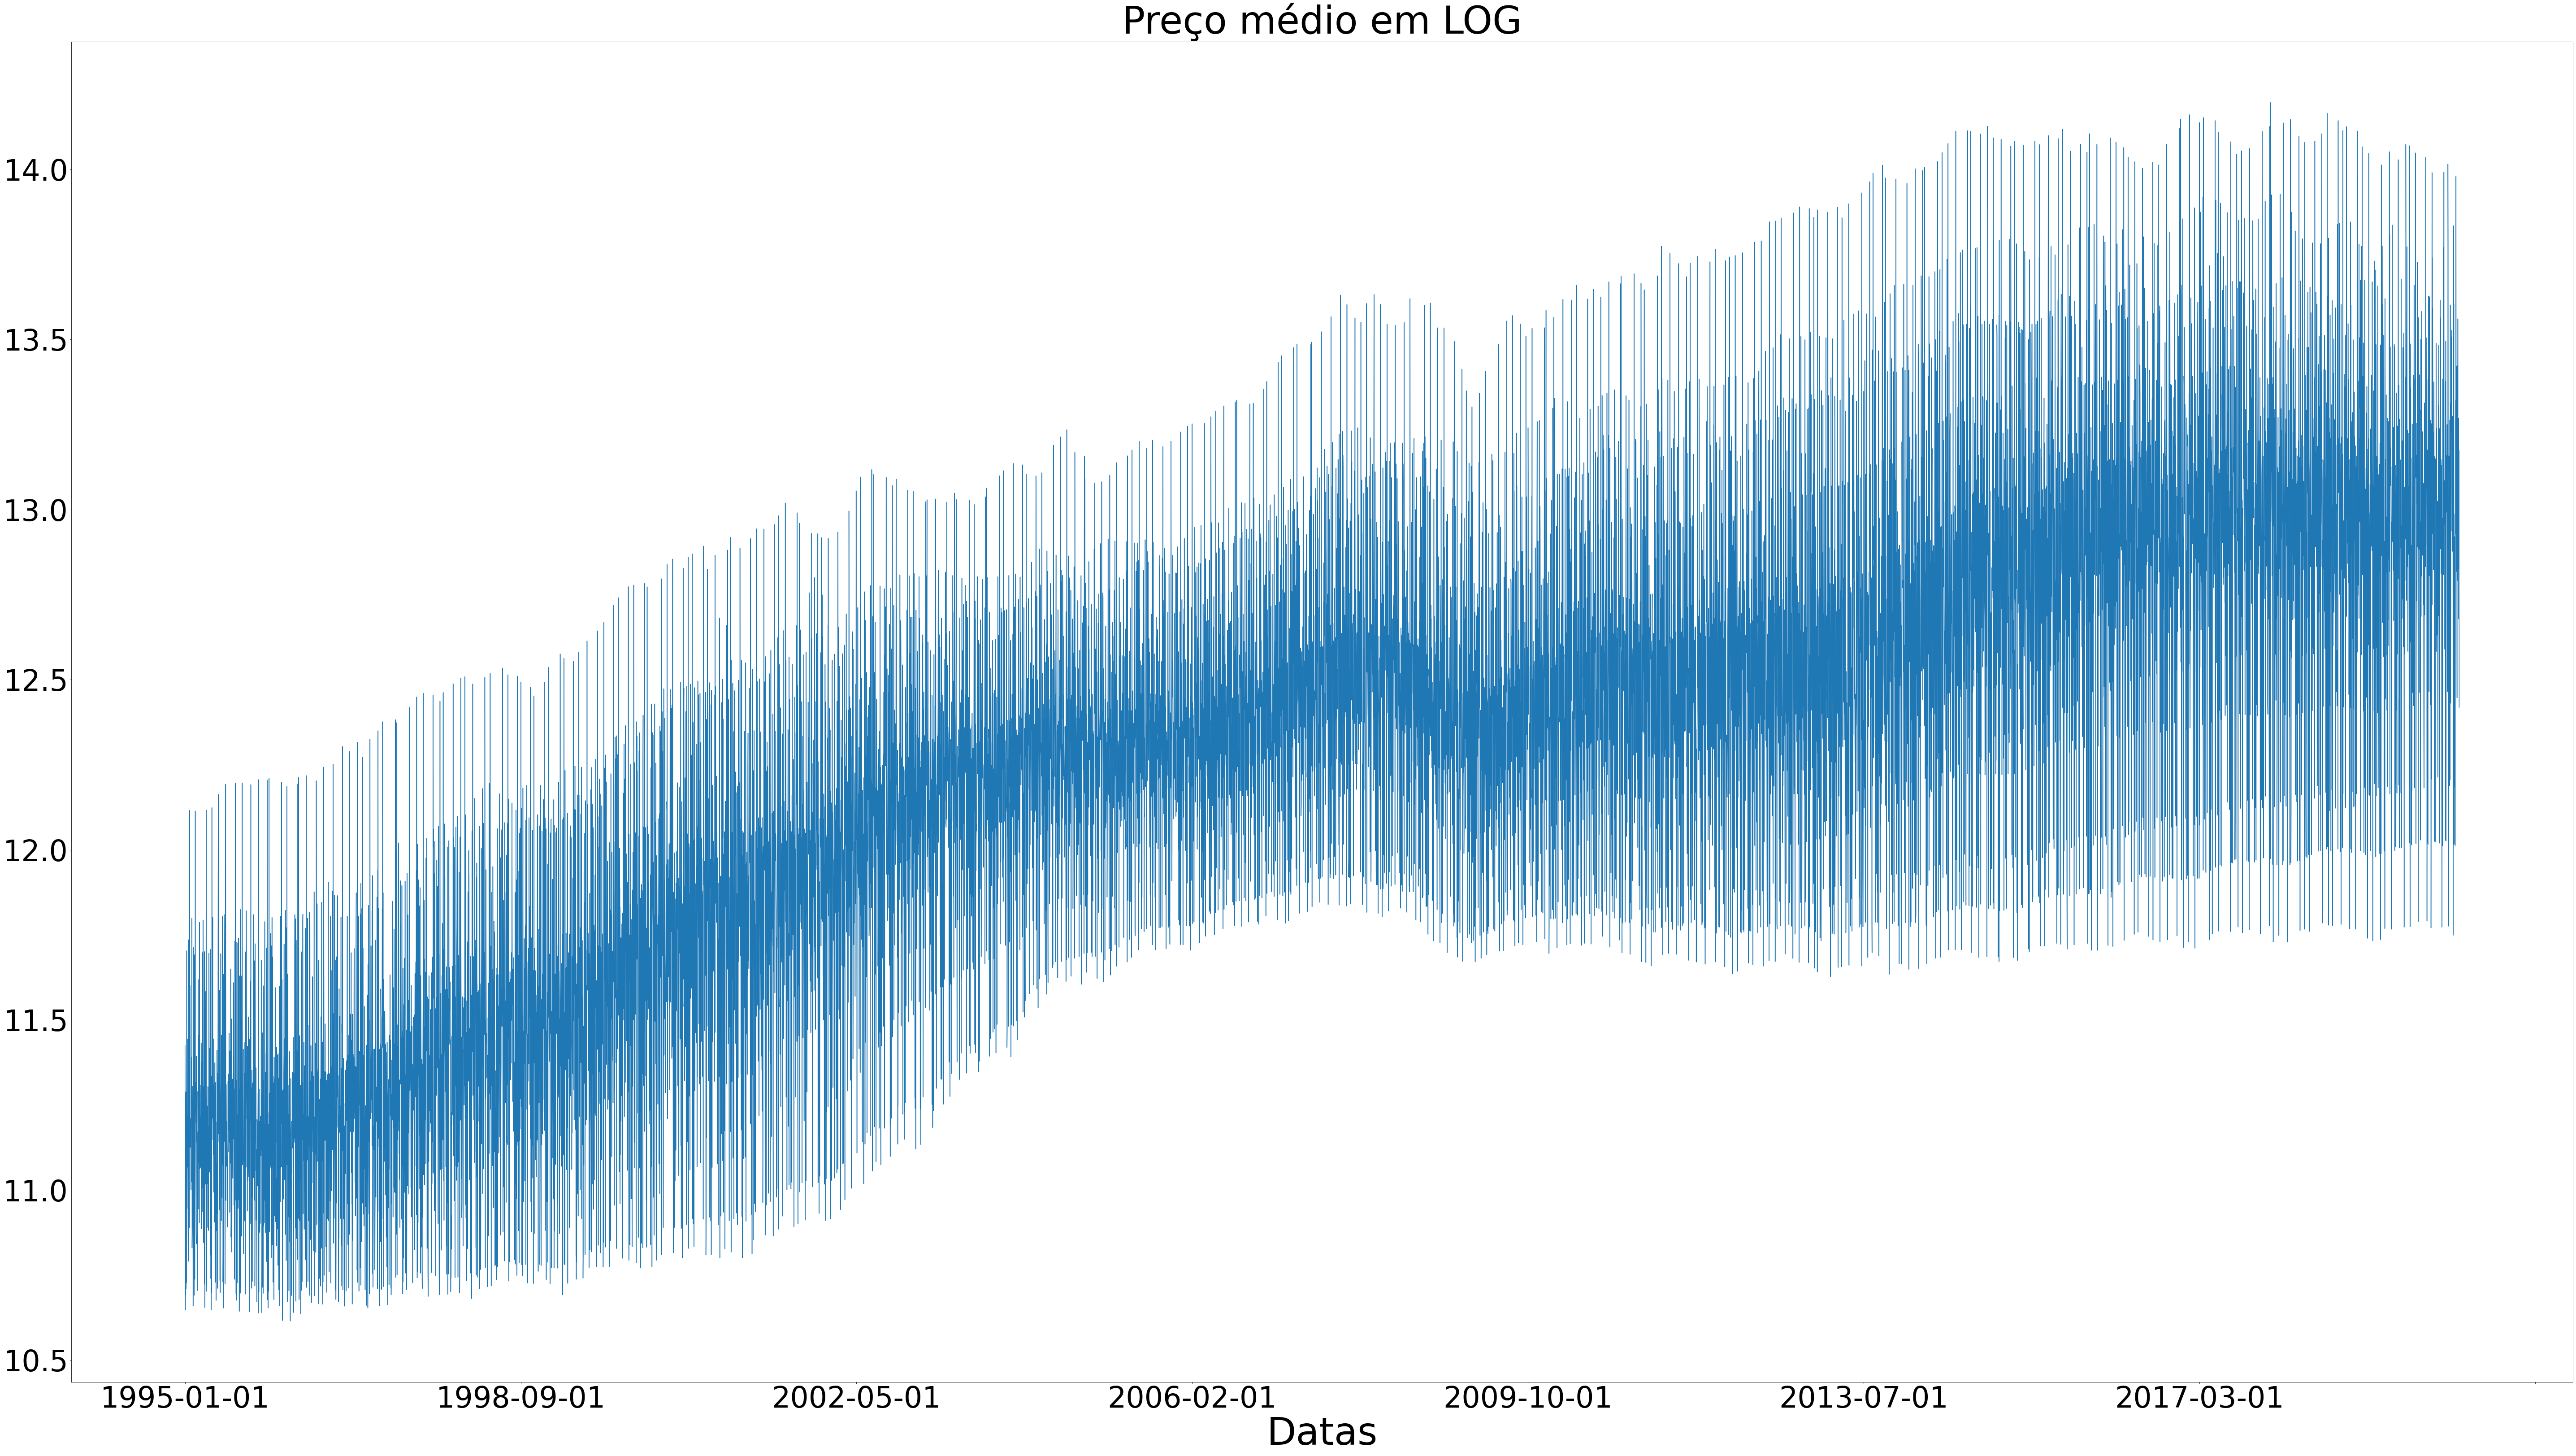

In [18]:
np.log(house['average_price']).plot(figsize=(100,55))
plt.xlabel('Datas',size=85)
plt.title('Preço médio em LOG',size=85)
plt.xticks(size=65)
plt.yticks(size=65)
plt.show()

Gráfico com o preços médios e o número de casas vendidas.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


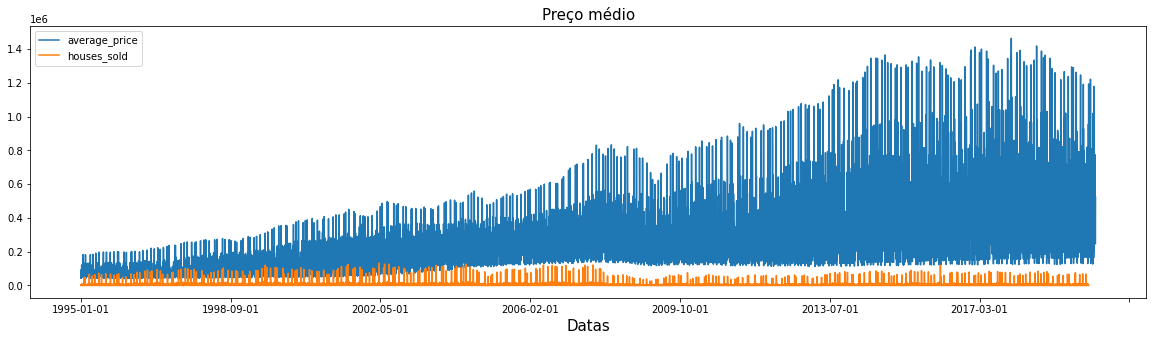

In [19]:
house[['average_price','houses_sold']].plot(figsize=(20,5))
plt.xlabel('Datas',size=15)
plt.title('Preço médio',size=15)
#plt.xticks(size=65)
#plt.yticks(size=65)
plt.show()

Agora abaixo é apenas os preços médios das casas da localidade de Londres, desconsiderando as outras localidades vemos que a série temporal dos preços é crescente. Há uma queda nos preços após 2007, provavelmente pela crise econômica que ocorreu entre 2007 e 2008; e por volta de 2015 os preços param de crescer e se mantém estáveis até 2020.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


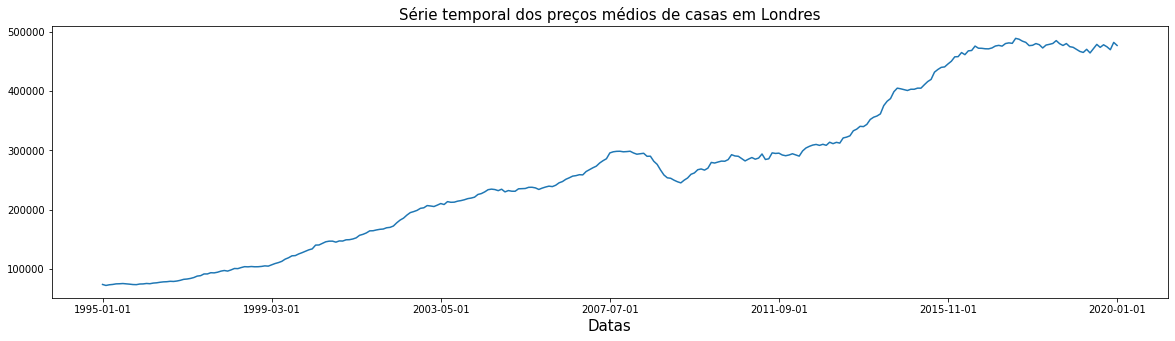

In [20]:
house[house['area']=='london']['average_price'].plot(figsize=(20,5))
plt.xlabel('Datas',size=15)
plt.title('Série temporal dos preços médios de casas em Londres', size=15)
plt.show()

Agora abaixo é apenas as casas vendidas na localidade de Londres, desconsiderando as outras localidades. O número de casas vendidas tem uma queda entre 2007 e 2008, provavelmente por conta da crise econômica mundial desse período. Após a crise a séria segue em um nível abaixo do nível pré-crise. Podemos ver também a presença de sazonalidade na série.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


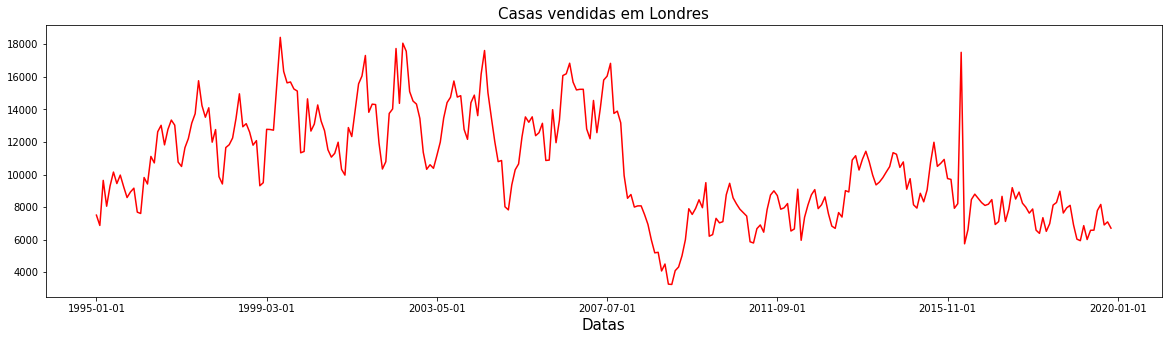

In [21]:
house[house['area']=='london']['houses_sold'].plot(figsize=(20,5),color='red')
plt.xlabel('Datas',size=15)
plt.title('Casas vendidas em Londres', size=15)
plt.show()

Abaixo podemos ver as séries logaritmizadas.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


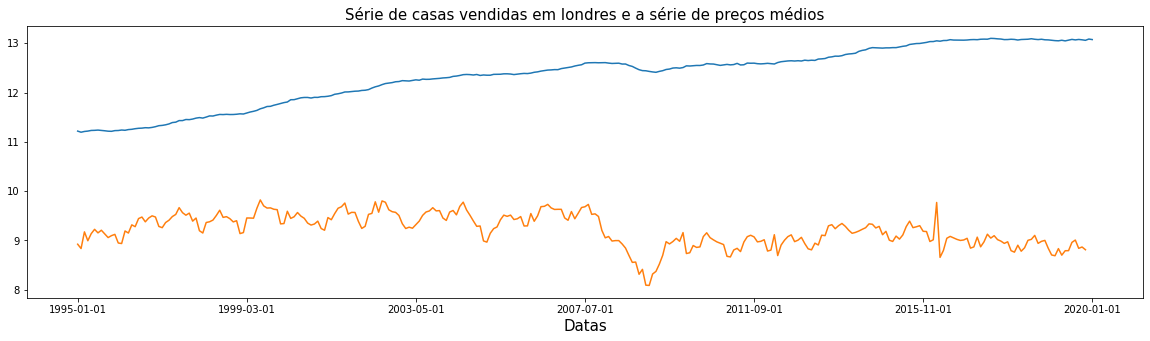

In [22]:
np.log(house[house['area']=='london']['average_price']).plot(figsize=(20,5))
np.log(house[house['area']=='london']['houses_sold']).plot(figsize=(20,5))
plt.xlabel('Datas',size=15)
plt.title('Série de casas vendidas em londres e a série de preços médios', size=15)
plt.show()

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


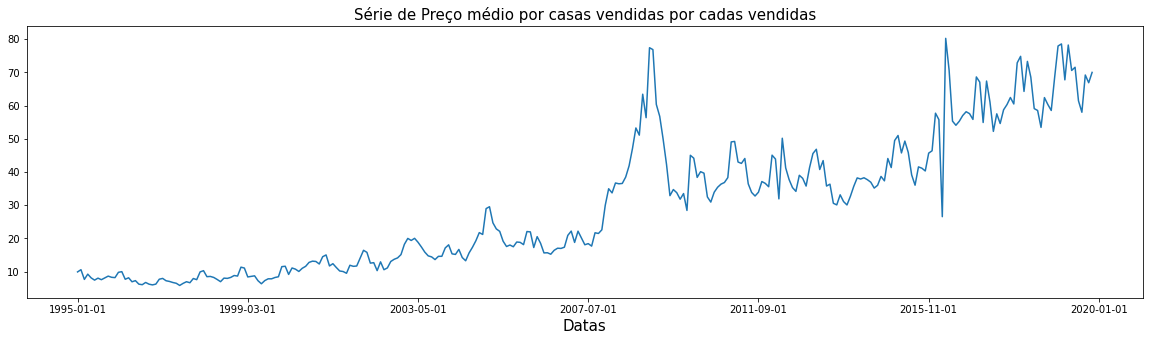

In [23]:
(house[house['area']=='london']['average_price']/house[house['area']=='london']['houses_sold']).plot(figsize=(20,5))
plt.title('Série de Preço médio por casas vendidas por cadas vendidas',size=15)
plt.xlabel('Datas',size=15)
plt.show()

## Selecionando os preços para a cidade de Londres

Criando uma nova série apenas com os preços das casas da localidade *london*.

In [24]:
house2=house[house['area']=='london']['average_price']

Tabela com as estatísticas descritivas.

In [25]:
house2.describe()

count       301.000000
mean     265517.425249
std      129153.712527
min       72778.000000
25%      152865.000000
50%      259115.000000
75%      340494.000000
max      488527.000000
Name: average_price, dtype: float64

Histograma da série temporal.

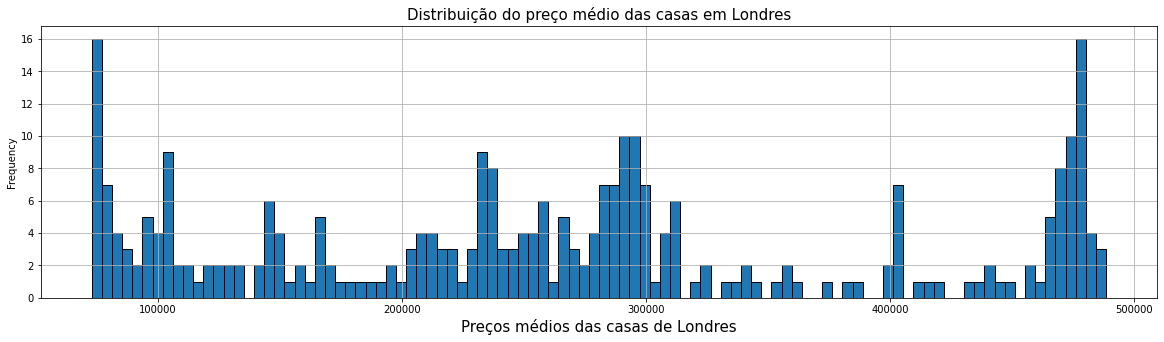

In [26]:
plt.figure(figsize=(20,5))
house2.plot.hist(bins=100,grid=True,edgecolor='k').autoscale(enable=True)
plt.xlabel('Preços médios das casas de Londres',size=15)
plt.title('Distribuição do preço médio das casas em Londres', size=15)
plt.show()

Gráfico de densidade da série temporal.

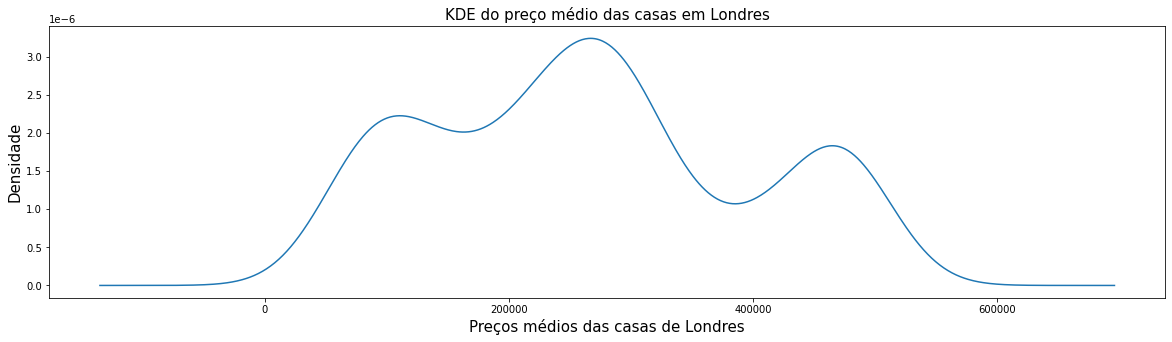

In [27]:
plt.figure(figsize=(20,5))
house2.plot.kde()
plt.xlabel('Preços médios das casas de Londres',size=15)
plt.ylabel('Densidade',size=15)
plt.title('KDE do preço médio das casas em Londres', size=15)
plt.show()

Preço médio das casas por localidade, ordenados do menor ao maior.

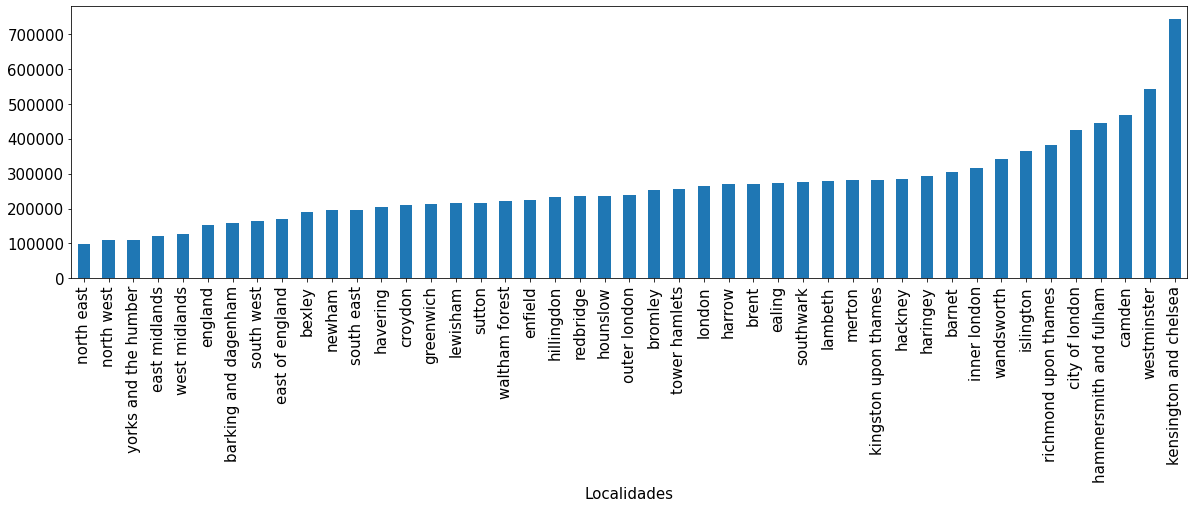

In [28]:
house.groupby('area')['average_price'].mean().sort_values().plot.bar(figsize=(20,5))
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Localidades',size=15)
plt.show()

Transformando a coluna 'month' em inteiro.

In [29]:
house['month']=house['month'].astype(int)

Valores médios das casas por ano.

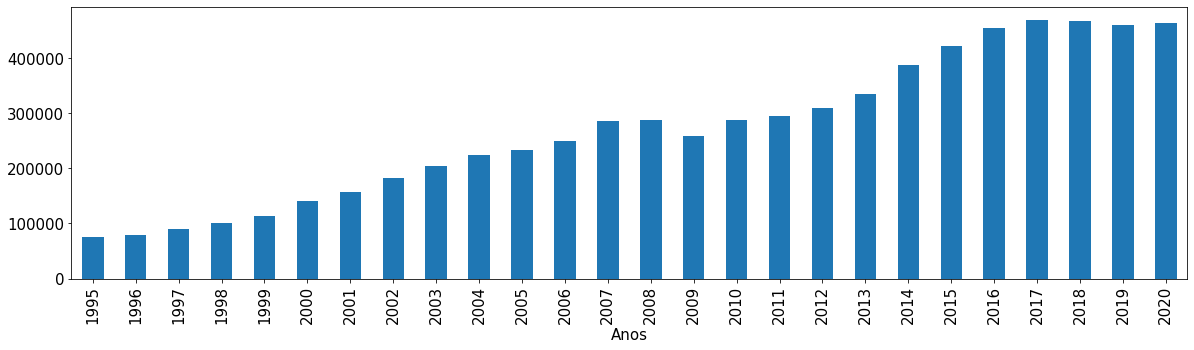

In [31]:
house.groupby('year')['average_price'].mean().plot.bar(figsize=(20,5))
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Anos',size=15)
plt.show()

## Decompondo a série com Filtro *Heidrick-Prescott* e com método ETS

Para analisar a série de preço médio das casas podemos decompor a série em componentes. Os componentes mais comuns de uma série temporal são a **tendência**, a **sazonalidade**, o **ciclo** e o **erro**.

O Filtro *Heidrick-Prescott* é um método matemático, muito usado em macroeconomia, para extrair o componente cíclico e a tendência de uma série temporal. A forma de decomposição do filtro é dada pela fórmula: $y_{t} = \tau_{t} + c_{t}$, onde $y_{t}$ é a série temporal, $\tau_{t}$ é a tendência e $c_{t}$ é o componente cíclico.

Já o método ETS decompõe a série em Erro, Tendência e Sazonalidade, sendo o erro o componente aleatório que não possui uma explicação. Aqui a série pode ser decomposta de forma aditiva ($y_{t} = \tau_{t} + s_{t} + e_{t}$) ou de forma multiplicativa ($y_{t} = \tau_{t}* s_{t} * e_{t}$).

### Decompondo a série com filtro Heidrick-Prescott

Extraindo o ciclo e a tendência.

In [32]:
house_cycle,house_trend=hpfilter(house2,lamb=1600)

Abaixo a série de ciclo da série de preços médio das casas.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


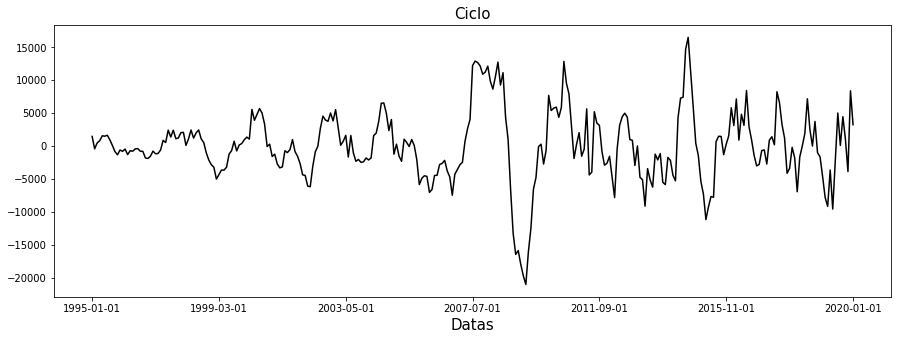

In [33]:
house_cycle.plot(figsize=(15,5),color='black')
plt.xlabel('Datas',size=15)
plt.title('Ciclo',size=15)
plt.show()

Abaixo a série de tendência.

C:\Users\junio\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


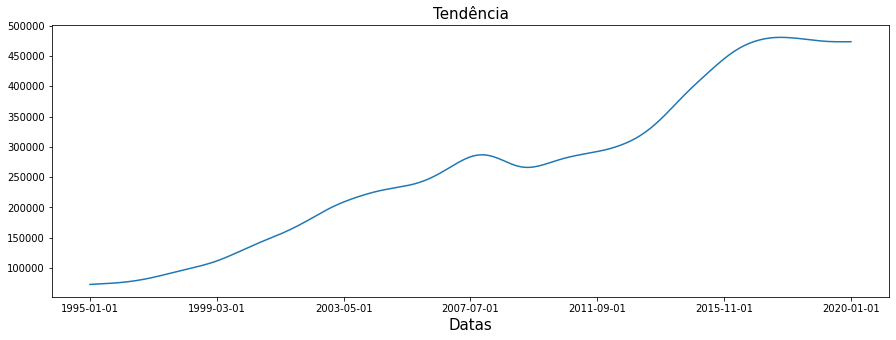

In [34]:
house_trend.plot(figsize=(15,5))
plt.xlabel('Datas',size=15)
plt.title('Tendência',size=15)
plt.show()

### Decompondo a série com o método ETS

In [35]:
house3=house2
house3.index=pd.to_datetime(house3.index)
result_decomp=seasonal_decompose(house3,model='additive')

Componente tendência da série *house2*.

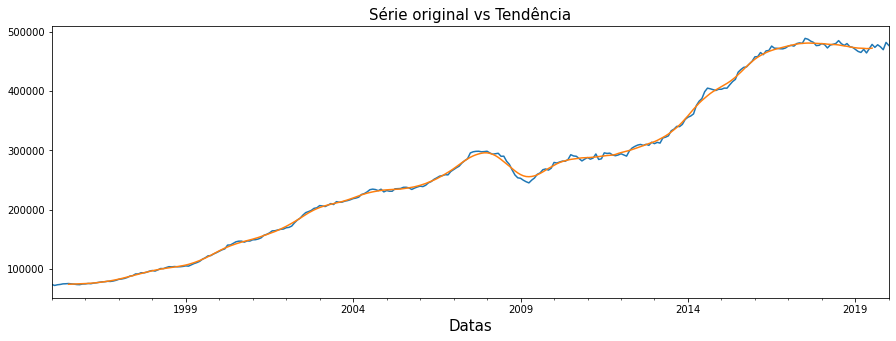

In [36]:
house3.plot()
result_decomp.trend.plot(figsize=(15,5))
plt.xlabel("Datas",size=15)
plt.title("Série original vs Tendência",size=15)
plt.show()

Abaixo o componente sazonal da série de preços de casas.

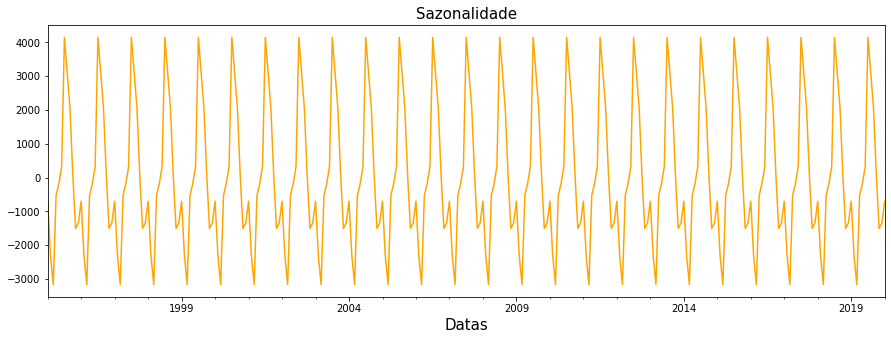

In [37]:
result_decomp.seasonal.plot(figsize=(15,5),color='orange')
plt.xlabel('Datas',size=15)
plt.title("Sazonalidade",size=15)
plt.show()

Notar que os resíduos são semelhantes ao ciclo, pois o método ETS não extrai o ciclo; consequentemente o ciclo vai para o resíduo da série.

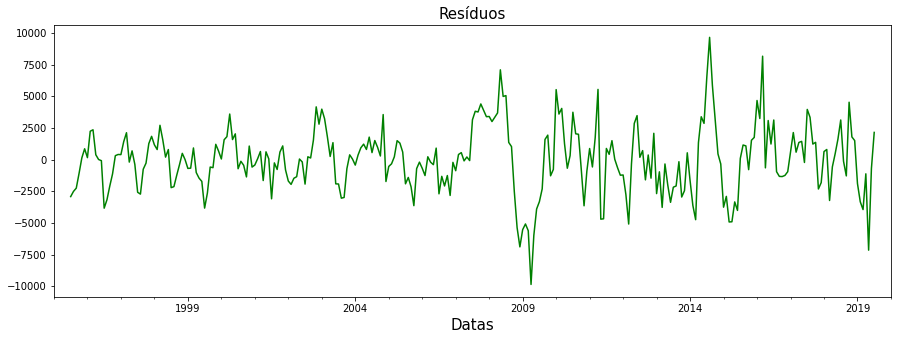

In [38]:
result_decomp.resid.plot(figsize=(15,5),color='green')
plt.xlabel('Datas',size=15)
plt.title("Resíduos",size=15)
plt.show()

Cada método de decomposição tem sua importância: o Filtro HP não consegue captar a sazonalidade diferente do método ETS que consegue; entretanto a vantagem do Filtro HP é que ele consegue extrair o ciclo, que o método ETS não consegue e, consequentemente, o componente cíclico acaba indo para os resíduos da série.

# Separando dados de treino e teste

Aqui iremos separar as 24 observações finais como dados de teste, ou seja, usaremos esses dados para comparar com as previsões que os algoritmos de suavização exponencial gerarão. As outras 277 observações seão usadas para treinar os algoritmos.

Definindo os dados de treino.

In [39]:
house_treino=house2.iloc[:-24]
house_treino

date
1995-01-01     74436
1995-02-01     72778
1995-03-01     73897
1995-04-01     74455
1995-05-01     75432
               ...  
2017-09-01    483833
2017-10-01    481762
2017-11-01    476290
2017-12-01    476848
2018-01-01    479772
Name: average_price, Length: 277, dtype: int64

Definindo os dados de teste.

In [40]:
house_teste=house2.iloc[-24:]
house_teste

date
2018-02-01    477860
2018-03-01    472357
2018-04-01    477253
2018-05-01    478485
2018-06-01    479931
2018-07-01    484724
2018-08-01    479550
2018-09-01    476545
2018-10-01    479775
2018-11-01    474551
2018-12-01    473454
2019-01-01    470067
2019-02-01    466500
2019-03-01    464818
2019-04-01    470092
2019-05-01    463976
2019-06-01    471053
2019-07-01    478348
2019-08-01    473390
2019-09-01    477727
2019-10-01    474318
2019-11-01    469422
2019-12-01    481710
2020-01-01    476588
Name: average_price, dtype: int64

Abaixo a série de preços: de cor preta as 277 observações que serão usadas para treinar os algoritmos e em vermelho as observações de treino.

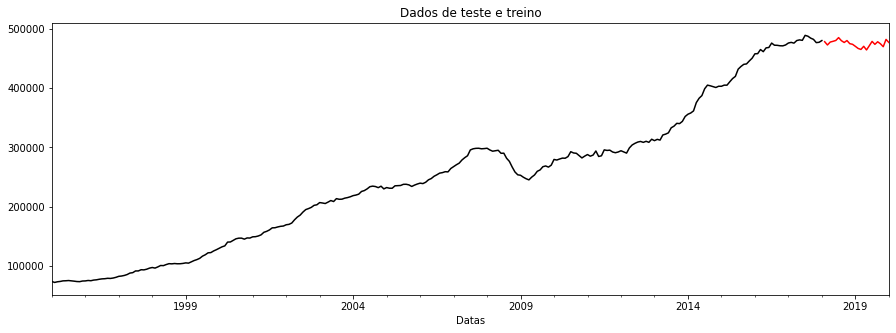

In [41]:
house_treino.plot(figsize=(15,5),color='black')
house_teste.plot(color='red')
plt.title("Dados de teste e treino")
plt.xlabel('Datas')
plt.show()

# Algoritmo de Suavização Simples

É o mais simples de todos os algoritmos e é o menos usado. Esse algoritmo só tem um componente não observável, que é o **Nível**. O nível não precisa ser globalmente fixo e pode evoluir ao longo do tempo.

A ideia central desse algoritmo é: O nível da série é estimado usando uma média ponderada entre as observações passadas ($Y_{t}, Y_{t-1}, Y_{t-2},..., Y_{t-n}$). Os pesos decrescem exponencialmente e são maiores para observações mais recentes. Ou seja, dado a constante $\alpha$ (que varia entre 0 e 1) a atribuição dos pesos segue o seguinte raciocínio, conforme tabela abaixo:

|                        || Observação || Peso dado a cada uma das observações       ||
|:----------------------:||:----------:||:-----------:||
|                        ||  $Y_{t}$   ||   $\alpha$  ||
|                        ||  $Y_{t-1}$ ||   $\alpha(1-\alpha)$  ||
|                        ||  $Y_{t-2}$ ||   $\alpha(1-\alpha)^{2}$  ||
|                        ||  $Y_{t-3}$ ||   $\alpha(1-\alpha)^{3}$  ||
|                        ||  $\dots$   ||   $\dots$  ||
|                        ||  $Y_{t-n}$ ||   $\alpha(1-\alpha)^{n}$  ||

Logo, com base na tabela acima, o nível é estimado da seguinte forma:

$N_{t}=\alpha.Y_{t} + \alpha(1-\alpha).Y_{t-1} +  \alpha(1-\alpha)^{2}.Y_{t-2} + \alpha(1-\alpha)^{3}.Y_{t-3} + \dots $

Essa fórmula pode ser resumida das seguinte forma:

Note que,

$N_{t-1}=\alpha.Y_{t-1} + \alpha(1-\alpha).Y_{t-2} +  \alpha(1-\alpha)^{2}.Y_{t-3} + \alpha(1-\alpha)^{3}.Y_{t-4} + \dots $

Multiplicando ambos os lados por $(1-\alpha)$


$(1-\alpha)N_{t-1}=\alpha.(1-\alpha)Y_{t-1} + \alpha(1-\alpha)^{2}.Y_{t-2} +  \alpha(1-\alpha)^{3}.Y_{t-3} + \alpha(1-\alpha)^{4}.Y_{t-4} + \dots $

Logo,

$(1-\alpha)N_{t-1} = N_{t} - \alpha.Y_{t} $

$ N_{t} = \alpha.Y_{t} + (1-\alpha)N_{t-1}$ (Forma de recorrência do algoritmo de suavização simples)

A nova estimativa é uma média ponderada antre a observação anterior e a nova observação.


O erro no instante t ($e_{t}$) é dado por: $e_{t} = Y_{t} - N_{t-1}$, logo $ Y_{t} = e_{t} + N_{t-1} $.

Substituindo na equação de recorrência do algoritmo, temos:

$ N_{t} = \alpha.(e_{t} + N_{t-1}) + (1-\alpha)N_{t-1}$

$ N_{t} = \alpha.e_{t} + \alpha.N_{t-1} + N_{t-1} - \alpha.N_{t-1}$

$ N_{t} = N_{t-1} + \alpha.e_{t}$ (Forma de correção de erro do algoritmo de suavização simples)


Abaixo iremos trabalhar com o algoritmo de suavização simples, intanciando o modelo, treinando e gerando as previsões com a biblioteca *Statsmodels*.

Definindo a frequência da série como mensal.

In [42]:
house_treino.index.freq='MS'

Treinando o modelo de **suavização exponecial simples**. Com base em testes feitos a constante de suavização que minimiza os erros é a de valor *0.111*.

In [43]:
model1=SimpleExpSmoothing(house_treino).fit(smoothing_level=0.111,optimized=True)

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


Gerando as previsões.

In [44]:
modelo1=model1.forecast(len(house_teste))
modelo1

2018-02-01    475280.279264
2018-03-01    475280.279264
2018-04-01    475280.279264
2018-05-01    475280.279264
2018-06-01    475280.279264
2018-07-01    475280.279264
2018-08-01    475280.279264
2018-09-01    475280.279264
2018-10-01    475280.279264
2018-11-01    475280.279264
2018-12-01    475280.279264
2019-01-01    475280.279264
2019-02-01    475280.279264
2019-03-01    475280.279264
2019-04-01    475280.279264
2019-05-01    475280.279264
2019-06-01    475280.279264
2019-07-01    475280.279264
2019-08-01    475280.279264
2019-09-01    475280.279264
2019-10-01    475280.279264
2019-11-01    475280.279264
2019-12-01    475280.279264
2020-01-01    475280.279264
Freq: MS, dtype: float64

## Algoritmo de Suavização *Holt*

O algoritmo de suavização *Holt* difere do algoritmo de suavização simples, pois é inserido um outro componente não observável: a tendência. A tendência são movimento de crescimento ou de decrescimento da série temporal e que ocorrem de forma sustentada. A tendência pode ser global (estar em toda série) ou local (em uma parte da série).

Dado que temos dois componente observáveis, não possuímos apenas uma equação, mas duas (uma de nível ($N_{t}$) e uma de tendência ($T_{t}$)) e duas constantes ( $\alpha$ e $\beta$ ) e são dadas abaixo:

$N_{t} = \alpha.Y_{t} + (1 - \alpha)(N_{t-1} + T_{t-1})$

$T_{t} = \beta(N_{t} - N_{t-1}) + (1 - \beta )T_{t-1} $

Onde, assim como anteriormente, $\alpha $ e $\beta$ variam entre 0 e 1.

A inicialização do algoritmo: $N_{2} = Y_{2}$ e $T_{2} = Y_{2} - Y_{1}$

Previsões: $Yprev_{t}(h) = N_{t} + hT_{t}$, h=1,2,3...

Sendo a equação de $e_{t} = Y_{t} - N_{t-1} - T_{t-1}$, temos que $ Y_{t}= e_{t} + N_{t-1} + T_{t-1}$

Substituindo $Y_{t}$ na equação de nível, temos:

$N_{t} = \alpha(e_{t} + N_{t-1} + T_{t-1}) + (1 - \alpha)(N_{t-1} + T_{t-1})$

$N_{t} = \alpha.e_{t} +\alpha.N_{t-1} + \alpha.T_{t-1} + N_{t-1} + T_{t-1} -\alpha.N_{t-1} -\alpha.T_{t-1}$

$N_{t} = N_{t-1} + T_{t-1} + \alpha.e_{t}$

Sendo $N_{t} - N_{t-1} = T_{t-1} + \alpha.e_{t}$ com base da equação anterior, vamos substituir esse resultado na fórmula de tendência:

$T_{t} = \beta(T_{t-1} + \alpha.e_{t}) + (1 - \beta )T_{t-1} $

$T_{t} = \beta.T_{t-1} + \beta.\alpha.e_{t} + T_{t-1}- \beta.T_{t-1}$

$T_{t} = T_{t-1} +  \beta.\alpha.e_{t}$

Logo, a forma de correção de erros de algoritmo de suavização Holt é:

$N_{t} = N_{t-1} + T_{t-1} + \alpha.e_{t}$

$T_{t} = T_{t-1} +  \beta.\alpha.e_{t}$

Abaixo iremos trabalhar com o Algoritmo de Holt, intanciando o modelo, treinando e gerando as previsões com a biblioteca *Statsmodels*.

**Treinando o modelo**

Com base nos testes realizados a constante que minimiza os erros é 0.7187 e optei por não inserir a constante *smoothing_slope*, pois com ela o erro aumenta, porém se usarmos *smoothing_slope=0.2* o erro será o menor possível, mas sem ela erro é ainda um pouco menor.

In [45]:
model2=Holt(house_treino).fit(smoothing_level=0.7187)

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Gerando as previsões.

In [46]:
modelo2=model2.forecast(len(house_teste))
modelo2

2018-02-01    477832.058299
2018-03-01    477570.928929
2018-04-01    477309.799559
2018-05-01    477048.670189
2018-06-01    476787.540819
2018-07-01    476526.411449
2018-08-01    476265.282079
2018-09-01    476004.152709
2018-10-01    475743.023339
2018-11-01    475481.893970
2018-12-01    475220.764600
2019-01-01    474959.635230
2019-02-01    474698.505860
2019-03-01    474437.376490
2019-04-01    474176.247120
2019-05-01    473915.117750
2019-06-01    473653.988380
2019-07-01    473392.859010
2019-08-01    473131.729640
2019-09-01    472870.600270
2019-10-01    472609.470900
2019-11-01    472348.341530
2019-12-01    472087.212160
2020-01-01    471826.082790
Freq: MS, dtype: float64

# Algoritmo de Suavização *Holt-Winter*

O algoritmo de suavização *Holt-Winters* possui uma componente não observável a mais que o algoritmo de *Holt*: A Sazonalidade. Sazonalidade são comportamentos que ocorrem na série temporal de forma repetitiva e com uma periodicidade inferior a um ano.

Assim sendo, o Holt-Winters possui **Nível** ($N_{t}$), **Tendência** ($T_{t}$) e **Sazonalidade** ($F_{t}$); e para cada uma desses componentes há uma constante de suavização, que serão, respectivamente, $\alpha$, $\beta$ e $\gamma$. Além disso haverão 3 equações para cada componente.

O algoritmo de suavização *Holt-Winters* pode ser **aditivo** ou **multiplicativo**.

### *Holt-Winter* Aditivo

O *Holt-Winter* aditivo é dado pelas equações abaixo:

$N_{t} = \alpha(Y_{t} - F_{t-s}) + (1 - \alpha)(N_{t-1} + T_{t-1})$

$T_{t} = \beta(N_{t} - N_{t-1}) + (1 - \beta )T_{t-1} $

$F_{t} = \gamma(Y_{t} - N_{t}) + (1 - \gamma)F_{t-s} $

0 < $\alpha$, $\beta$ e $\gamma$ < 1.

Forma de correção de erros do algoritmo *Holt-Winters*:

$N_{t} = N_{t-1} + T_{t-1} + \alpha.e_{t}$

$T_{t} = T_{t-1} + \alpha.\beta.e_{t}$

$F_{t} = F_{t-s} + \gamma(1 - \alpha)e_{t}$

Abaixo trabalharemos com esse algoritmo e geraremos previsões.

**Treinando o algoritmo de suavização Holt-Winters aditivo**

In [47]:
model3=ExponentialSmoothing(house_treino,trend='add',seasonal='add').fit()

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Gerando as previsões para os 24 períodos.

In [48]:
modelo3=model3.forecast(len(house_teste))
modelo3

2018-02-01    477625.037838
2018-03-01    476313.599124
2018-04-01    478554.577100
2018-05-01    478465.362111
2018-06-01    476777.479545
2018-07-01    480670.341499
2018-08-01    476256.376188
2018-09-01    472896.071784
2018-10-01    469742.667694
2018-11-01    468105.844099
2018-12-01    470353.302406
2019-01-01    471788.422140
2019-02-01    469862.349649
2019-03-01    468550.910936
2019-04-01    470791.888911
2019-05-01    470702.673922
2019-06-01    469014.791356
2019-07-01    472907.653310
2019-08-01    468493.687999
2019-09-01    465133.383595
2019-10-01    461979.979505
2019-11-01    460343.155910
2019-12-01    462590.614217
2020-01-01    464025.733951
Freq: MS, dtype: float64

### *Holt-Winters* Multiplicativo

O algoritmo *Holt-Winters* multiplicativo é dado pelas equações abaixo. A diferença entre o aditivo e o multiplicativo é que onde há diferença é substituído pela razão entre os componentes.

$N_{t} = \alpha(\frac{Y_{t}}{F_{t-s}}) + (1 - \alpha)(N_{t-1} + T_{t-1})$

$T_{t} = \beta(N_{t} - N_{t-1}) + (1 - \beta )T_{t-1} $

$F_{t} = \gamma(\frac{Y_{t}}{N_{t}}) + (1 - \gamma)F_{t-s} $

e a forma de correção de erros é dada por:

$N_{t} = N_{t-1} + T_{t-1} + \alpha\frac{e_{t}}{F_{t-s}}$

$T_{t} = T_{t-1} + \alpha.\beta.\frac{e_{t}}{F_{t-s}}$

$F_{t} = F_{t-s} + \gamma(1 - \alpha)\frac{e_{t}}{F_{t-s}}$

Em seguida iremos trabalha com esse algoritmo.

**Treinando o algoritmo Holt-Winters Multiplicativo**

In [49]:
model4=ExponentialSmoothing(house_treino,trend='add',seasonal='mul').fit()

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Gerando as previsões.

In [50]:
modelo4=model4.forecast(len(house_teste))
modelo4

2018-02-01    477564.544791
2018-03-01    476589.843040
2018-04-01    481571.335735
2018-05-01    484514.185831
2018-06-01    486179.585269
2018-07-01    496667.153917
2018-08-01    497061.667228
2018-09-01    496332.317038
2018-10-01    492822.977746
2018-11-01    488687.250981
2018-12-01    489440.445076
2019-01-01    490903.708269
2019-02-01    489289.380672
2019-03-01    488266.858212
2019-04-01    493346.361534
2019-05-01    496337.077639
2019-06-01    498019.040309
2019-07-01    508737.507648
2019-08-01    509117.193543
2019-09-01    508345.873017
2019-10-01    504727.579116
2019-11-01    500468.234931
2019-12-01    501215.930214
2020-01-01    502690.766024
Freq: MS, dtype: float64

## Algoritmo de Suavização *Pegels*

Agora vamo falar sobre um algoritmo de suavização pouco usado, que é o algoritmo de *Pegels*. Ele se diferencia do *Holt* pelo fato de adicionar a tendência de forma multiplicativa e isso pode ser extendido para o caso sazonal.

Esse algoritmo é dado por:


$N_{t} = \alpha.Y_{t} + (1 - \alpha)(N_{t-1} * T_{t-1})$

$T_{t} = \beta\frac{N_{t}}{N_{t-1}} + (1 - \beta )T_{t-1} $

As previsões são geradas da seguinte forma: $Yprev_{h} = N_{t} * T^{h}_{t-1}$, onde h = 1,2,3...

E a forma de correção de erros é dada por:

$N_{t} = N_{t-1} * T_{t-1} + \alpha.e_{t}$

$T_{t} = T_{t-1} +  \beta.\alpha.\frac{e_{t}}{N_{t-1}}$

Abaixo as previsões geradas por esse algoritmo.

**Treinando o modelo**, a diferença para o *Holt* é que estamos colocando a tendência de forma multiplicativa e aqui colocaremos a sazonalidade de forma aditiva.

In [51]:
model5=ExponentialSmoothing(house_treino,trend='mul',seasonal='add').fit()

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Gerando as previsões.

In [52]:
modelo5=model5.forecast(len(house_teste))
modelo5

2018-02-01    477621.832785
2018-03-01    476304.365937
2018-04-01    478543.457509
2018-05-01    478460.580574
2018-06-01    476780.739231
2018-07-01    480694.443076
2018-08-01    476291.032648
2018-09-01    472931.594383
2018-10-01    469784.438100
2018-11-01    468162.635174
2018-12-01    470428.370569
2019-01-01    471879.763235
2019-02-01    469956.516094
2019-03-01    468646.603691
2019-04-01    470893.242264
2019-05-01    470817.904891
2019-06-01    469145.595680
2019-07-01    473066.824234
2019-08-01    468670.931098
2019-09-01    465319.002717
2019-10-01    462179.348917
2019-11-01    460565.041080
2019-12-01    462838.264178
2020-01-01    464297.137167
Freq: MS, dtype: float64

## Algoritmo de Suavização *Pegels* Multiplicativo

Aqui iremos alterar o parâmetro *'seasonal'* para *'mul'* e estaremos inserindo a sazonalidade de forma multiplicativa no algoritmo.

Treinando o algoritmo de suavização Pegels com sazonalidade multiplicativa.

In [59]:
model6=ExponentialSmoothing(house_treino,trend='mul',seasonal='mul').fit()

C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\junio\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Gerando as previsões.

In [60]:
modelo6=model6.forecast(len(house_teste))
modelo6

2018-02-01    1.255894e+07
2018-03-01    2.618100e+07
2018-04-01    5.014140e+07
2018-05-01    7.437737e+07
2018-06-01    6.017758e+07
2018-07-01    1.646906e+07
2018-08-01    1.518097e+06
2018-09-01    1.461657e+06
2018-10-01    2.608760e+06
2018-11-01    5.093651e+06
2018-12-01    1.078367e+07
2019-01-01    2.744651e+07
2019-02-01    5.957905e+07
2019-03-01    1.242016e+08
2019-04-01    2.378686e+08
2019-05-01    3.528430e+08
2019-06-01    2.854798e+08
2019-07-01    7.812850e+07
2019-08-01    7.201785e+06
2019-09-01    6.934040e+06
2019-10-01    1.237585e+07
2019-11-01    2.416406e+07
2019-12-01    5.115726e+07
2020-01-01    1.302051e+08
Freq: MS, dtype: float64

## Comparando os resultados dos algoritmos

Aqui serão gerados gráficos das observações usadas como teste com as previsões, as métricas (erro médios absolutos e quadrados) e a tabela comparando os resultados.

**Plotando a base de teste e as previsões**

Observação: as previsões do modelo 4 estão sobreposta às previsões do modelo 6 (notar que o erro médios obtidos desses modelos são muito próximos).

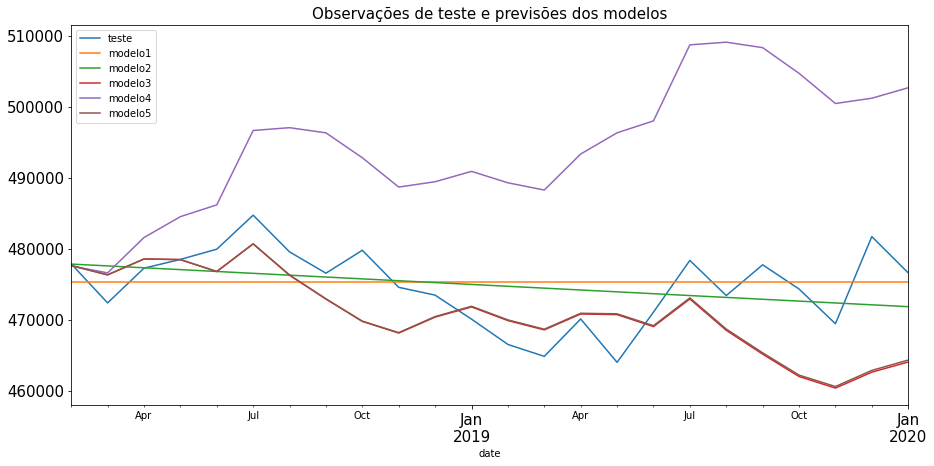

In [56]:
house_teste.plot(figsize=(15,7))
modelo1.plot()
modelo2.plot()
modelo3.plot()
modelo4.plot()
modelo5.plot()
#modelo6.plot()
plt.title("Observações de teste e previsões dos modelos", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
lista=['teste','modelo1','modelo2','modelo3','modelo4','modelo5']
plt.legend(lista)
plt.show()

## Métricas

O melhor modelo será aquele que possui o menor erro. Como estamos trabalhando com variáveis contínuas, usaremos as métricas **MAE** e o **RMSE** (que são as métricas mais comuns).


No **MAE** a magnitude média dos erros de um conjunto de previsões, sem considerar sua direção. É a média amostral absoluta entre a previsão e o que realmente ocorreu; e para cada diferença há um mesmo peso.
O **MAE** (Mean Absolute Erro - Erro médio absoluto) é dado pela fórmula:

$\frac{\sum_{t=1}^{n}|Y_{t} - Yprev_{t}|}{n}$ ou $\frac{\sum_{t=1}^{n}|e_{t}|}{n}$

O **RMSE** usa uma métrica quadrada e, assim como o **MAE**, mede a magnitude dos erros. A diferença, entretanto, é que o **RSME** atribui pesos para cada erro, sendo que os maiores pesos são dados aos maiores erros (uma forma de penalização).
O **RMSE** (Root Mean Squared Erro - Raiz do Erro médio quadrado) é dado pela fórmula:

$\sqrt\frac{\sum_{t=1}^{n}(Y_{t} - Yprev_{t})^{2}}{n}$ ou $\sqrt\frac{\sum_{t=1}^{n}e_{t}^{2}}{n}$

Não existe um método melhor do que o outro. O **RMSE** tem a vantagem de penalização de erros, já o **MAE** tem a vantagem de ser melhor interpretado. Por esse motivo usaremos as duas métricas.

In [57]:
print('*************Métricas do Algoritmo de Suavização Simples*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Simples :',round(mean_absolute_error(house_teste,modelo1),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Simples :',round(mean_squared_error(house_teste,modelo1)**0.5,3))


print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt:',round(mean_absolute_error(house_teste,modelo2),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização',round(mean_squared_error(house_teste,modelo2)**0.5,3))

print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt-Winters aditivo*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters aditivo :', round(mean_absolute_error(house_teste,modelo3),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters aditivo :',round(mean_squared_error(house_teste,modelo3)**0.5,3))

print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Holt-Winters multiplicativo*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_absolute_error(house_teste,modelo4),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_squared_error(house_teste,modelo4)**0.5,3))

print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Pegels aditivo *************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Pegels aditivo :',round(mean_absolute_error(house_teste,modelo5),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Pegels aditivo :',round(mean_squared_error(house_teste,modelo5)**0.5,3))

print(' '*254)
print('*************Métricas do Algoritmo de Suavização de Pegels multiplicativo*************')
print(' '*254)
print('Erro médio absoluto do Algoritmo de Suavização Pegels multiplicativo:',round(mean_absolute_error(house_teste,modelo6),3))
print('Raiz do erro médio quadrado do Algoritmo de Suavização Pegels multiplicativo:',round(mean_squared_error(house_teste,modelo6)**0.5,3))

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 4354.083
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 5274.341
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                                  

## Tabela comparativa

Com base na métrica **MAE** (erro médio absoluto) o algoritmo que teve o melhor desempenho (o menor erro) foi o algoritmo de **Pegels com sazonalidade aditiva** (erro médio absoluto foi de 3981.576), porém considerando o a métrica **RMSE** o melhor algoritmo foi o **Holt** (com raiz do erro médio quadrático igual a 5122.889).

|                                               || Erro Médio absoluto || Raiz do erro médio quadrado||
|:------------------------------:||:-----------:||:------------:||
|Algoritmo de Suavização Simples                ||   4354.083     ||  5274.341       ||
|**Algoritmo de Suavização de Holt**                ||   4041.854     ||   **5122.889**     ||
|Algoritmo de Suavização de Holt-Winters aditivo||  4348.574      ||   5706.712     ||
|Algoritmo de Suavização de Holt-Winters multiplicativo||   8337.700     ||  9829.741     ||
|**Algoritmo de Suavização de Pegels aditivo**   ||   **3981.576**     ||  5261.611     ||

Abaixo o gráfico da série e com as previsões e as observações de teste.

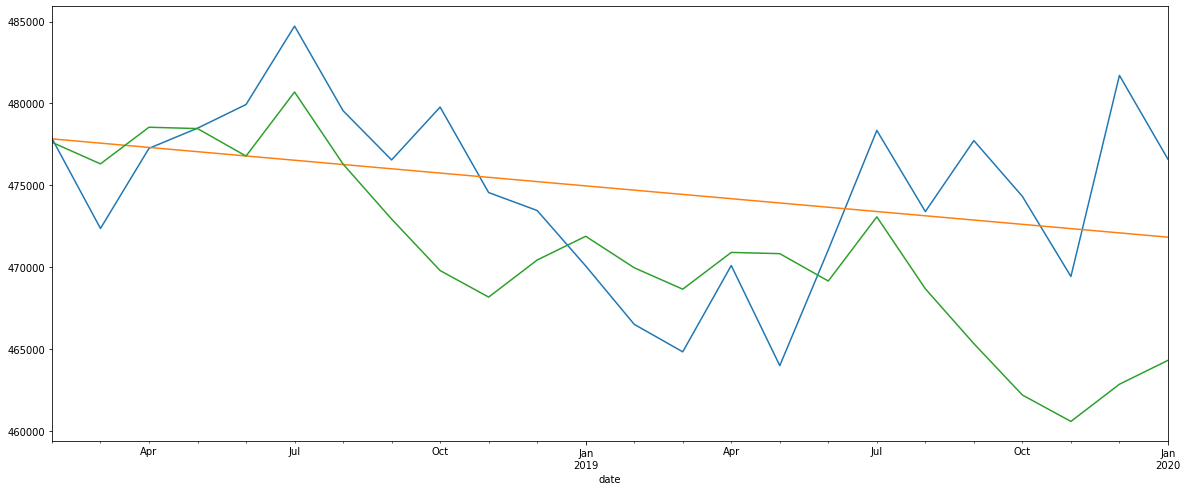

In [58]:
house_teste.plot(figsize=(20,8))
modelo2.plot()
modelo5.plot()
plt.show()

## Conclusão
Considerando a geração de previsões mais realista eu usaria o algoritmo de suavização **Pegels aditivo** (pois ele consegue captar a sazonalidade do período analisado.

Enfim, esse trabalho tem como objetivo apresentar, explicar e utilizar algoritmos determinísticos usados para modelagem de séries temporais. Por mais que sejam algoritmos simples de entendimento e aplicação, ainda assim, são bastante conhecidos e utilizados em setores da economia para gerar previsões (de demanda, orçamento, preços, inflação, etc.).